In [165]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
%autoreload
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nexus_tool.weap_tools import get_zonal_stats
import fiona
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support

In [167]:
cropland = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200227.csv", encoding='utf-8')
cropland.drop(columns=['WKT', 'gen2013', 'area'], inplace=True)
cropland.reset_index(inplace=True)
cropland.rename(columns={'area_ha': 'area_m2', 'index': 'Demand point', 'prov': 'province', 'wtd_mean': 'wtd'}, inplace=True)
cropland.columns = cropland.columns.str.replace('mean','')
cropland.columns = cropland.columns.str.replace('mea','')
for column in list(cropland)[1:-3]:
    cropland.loc[cropland[column]=='', column] = np.nan

builtarea = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\builtup_2013_processed_20200218_clean.csv", encoding='utf-8')
builtarea.drop(columns=['WKT', 'fid', 'DN'], inplace=True)

provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
demand_sites = gpd.read_file('Morocco dashboard/spatial_data/Demand_points.gpkg', encoding='utf-8')

In [168]:
MerchidSudMoroc = 26192
for gdf in [provinces, demand_sites]:
    gdf.to_crs(epsg=MerchidSudMoroc, inplace=True)

for column in list(cropland)[1:-3]:
    cropland[column] = cropland[column].astype('float')
    cropland[column] = cropland[column].interpolate()
cropland['wtd'] = cropland['wtd'].astype('float')
    
for column in list(builtarea)[0:-2]:
    builtarea[column] = builtarea[column].astype('float')

cropland.crs = f'epsg:{MerchidSudMoroc}'
cropland = cropland.loc[cropland.area_m2>=100] #choose
    
builtarea.crs = f'epsg:{MerchidSudMoroc}'
builtarea = builtarea.loc[builtarea.area_m2>=10000] #choose
builtarea = gpd.clip(builtarea, provinces, keep_geom_type=True)

builtarea.reset_index(inplace=True, drop=True)
builtarea.reset_index(inplace=True)
builtarea.rename(columns={'index': 'Demand point', 'prov': 'province'}, inplace=True)

C:\Users\camilorg\AppData\Local\Continuum\anaconda3\envs\geoenv\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


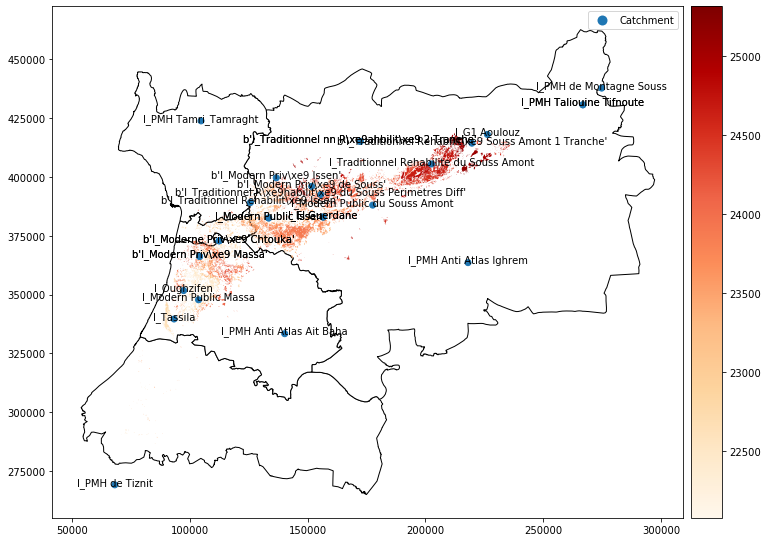

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
cropland.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)
demand_sites.loc[demand_sites['type']=='Catchment'].plot(ax=ax, column='type', legend=True)
for idx, row in demand_sites.loc[demand_sites['type']=='Catchment'].iterrows():
    ax.annotate(s=row['point'], xy=row.geometry.centroid.coords[0],
                 horizontalalignment='center')

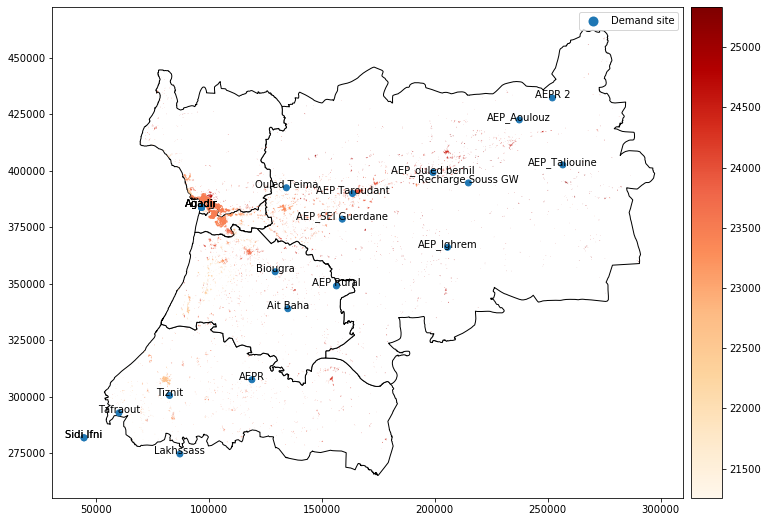

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
builtarea.plot(column='_srad7', ax=ax, cmap='OrRd', legend=True, cax=cax)
demand_sites.loc[demand_sites['type']=='Demand site'].plot(ax=ax, column='type', legend=True)
for idx, row in demand_sites.loc[demand_sites['type']=='Demand site'].iterrows():
    ax.annotate(s=row['point'], xy=row.geometry.centroid.coords[0],
                 horizontalalignment='center')

In [171]:
dff = cropland.loc[cropland.province=='Taroudannt', 'wtd']
cropland.loc[cropland.province=='Taroudannt', 'wtd'] *= 170 * dff.count() / dff.sum()
dff = cropland.loc[cropland.province=='Chtouka-Aït Baha', 'wtd']
cropland.loc[cropland.province=='Chtouka-Aït Baha', 'wtd'] *= 85 * dff.count() / dff.sum()

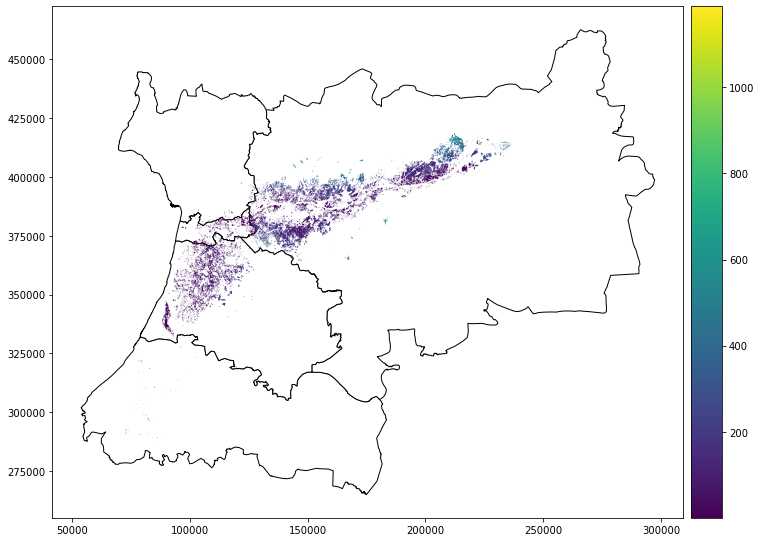

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
cropland.plot(column='wtd', ax=ax, legend=True, cax=cax)

In [173]:
def create_time_data(data, first_year, end_year):
    df = pd.DataFrame()
    df['Year'] = list(itertools.chain.from_iterable([[year]*12*data.shape[0] for year in range(first_year,end_year+1)]))
    y_number = df.Year.unique().shape[0]
    dff = pd.DataFrame(data.filter(regex='_srad|province|Demand point|area|wtd').melt(id_vars=['Demand point','province','area_m2','wtd']))
    dff.rename(columns={'variable': 'Month', 'value': 'srad'}, inplace=True) 
    dff = dff.join(data.filter(like='_wind').melt())
    dff.rename(columns={'value': 'wind'}, inplace=True)
    dff.drop(columns=['variable'], inplace=True)
    dff['Month'] = dff['Month'].str.replace('_srad','').astype(int)
    dff.sort_values(['province','Month'], inplace=True)
    dff.reset_index(drop=True, inplace=True)
    df = df.join(pd.concat([dff]*y_number, ignore_index=True))
    df['Date'] = pd.to_datetime(df[['Year','Month']].join(pd.DataFrame({'day': [1]*df.shape[0]})))
    return df

In [174]:
df_cropland = create_time_data(cropland, 2019, 2050)

In [177]:
df_cropland

,Year,Demand point,province,area_m2,wtd,Month,srad,wind,Date
0,2019,7579,Agadir-Ida ou Tanane,102166.996364,3.569033,1,12350.049290,2.988044,2019-01-01
1,2019,7580,Agadir-Ida ou Tanane,98718.747355,7.954429,1,12269.503302,2.929310,2019-01-01
2,2019,7581,Agadir-Ida ou Tanane,229879.711173,7.770243,1,12268.392943,2.908396,2019-01-01
3,2019,7582,Agadir-Ida ou Tanane,11281.955150,6.211865,1,12389.000000,3.400000,2019-01-01
4,2019,7583,Agadir-Ida ou Tanane,13997.885311,8.175929,1,12447.000000,3.600000,2019-01-01
...,...,...,...,...,...,...,...,...,...
2949115,2050,7573,Tiznit,13669.581362,28.623457,12,11741.836144,3.487753,2050-12-01
2949116,2050,7574,Tiznit,21682.015688,43.851391,12,11830.000000,3.200000,2050-12-01
2949117,2050,7575,Tiznit,43678.614711,17.972042,12,11738.000000,3.600000,2050-12-01
2949118,2050,7576,Tiznit,63708.064298,0.964995,12,11739.000000,3.700000,2050-12-01


In [178]:
def get_area_share(df, by, value):
    dff = df.groupby(by)[value].sum().copy()
    return df[value] / df.set_index(by).index.map(dff)

In [179]:
cropland_temp = cropland.copy()
cropland_temp.loc[cropland_temp['province']=='Inezgane-Aït Melloul', 'province'] = 'Taroudannt'
df_cropland['area_share'] = df_cropland['Demand point'].map(get_area_share(cropland_temp, 'province', 'area_m2'))

# builtarea_temp = builtarea.copy()
# builtarea_temp.loc[builtarea_temp['province']=='Inezgane-Aït Melloul', 'province'] = 'Agadir-Ida ou Tanane'
# df_builtarea['area_share'] = df_builtarea['Demand point'].map(get_area_share(builtarea_temp, 'province', 'area_m2'))

In [181]:
output_folder = r'Data - Souss-Massa/Cropland and Builtarea'
cropland.to_crs('epsg:4326').to_file(r"Data - Souss-Massa\GIS\Processed layers/cropland.geojson", driver='GeoJSON')
df_cropland.to_csv(os.path.join(output_folder, 'cropland.csv'), index=False)
# df_builtarea.to_csv(os.path.join(output_folder, 'builtarea.csv'), index=False)